In [1]:
import time 
import traceback
import mysql.connector
from mysql.connector import Error
from mysql.connector import pooling



DATABASE = 'nekretnine'
USERNAME = 'root'
PASSWORD = 'password'


class DatabaseManager:
    
    def __init__(self):
        self.connection_pool=None
        
    def createConnectionPool(self):
        self.connection_pool = pooling.MySQLConnectionPool(pool_name="pynative_pool",
                                                  pool_size=5,
                                                  pool_reset_session=True,
                                                  host='localhost',
                                                  database=DATABASE,
                                                  user=USERNAME,
                                                  password=PASSWORD)

        
    def executeSelectQuery(self, query):
        result=None
        try:
            connection = self.connection_pool.get_connection()
            cursor = connection.cursor()
            cursor.execute(query)
            result = cursor.fetchall()
            print('record gotten')
        except Error as e:
            print("Error while connecting to MySQL using Connection pool ", e)
        finally:
            # closing database connection.
            if connection.is_connected():
                cursor.close()
            connection.close()
            return result;
            
            

In [ ]:
name=input('Hi stranger ')
print(name)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class LinearRegressionApp:
    def __init__(self):
        self.databaseManager = None
        self.columnNames = ['PartOfTheCity', 'ObjectType', 'SquareFootage', 'TotalRooms', 'Price']
        
    def createDataFrame(self, turpleData):
        df = pd.DataFrame(turpleData, columns = self.columnNames)
        return df
    
    def feature_normalize(self, X):
        mu = np.mean(X, axis = 0)  
        # Notice the parameter ddof (Delta Degrees of Freedom)  value is 1
        sigma = np.std(X, axis= 0, ddof = 1, dtype=np.float64)  # Standard deviation (can also use range)
        X_norm = (X - mu)/sigma
        return X_norm, mu, sigma
    
    def compute_cost(self, X, y, theta, m):
        predictions = X.dot(theta)
        #print('predictions= ', predictions[:5])
        errors = np.subtract(predictions, y)
        #print('errors= ', errors[:5]) 
        sqrErrors = np.square(errors)
        J = 1/(2 * m) * errors.T.dot(errors)

        return J
    
    def gradient_descent(self, X, y, theta, alpha, iterations, m):
        cost_history = np.zeros(iterations)        
        

        for i in range(iterations):
            predictions = X.dot(theta)
            #print('predictions= ', predictions[:5])
            errors = np.subtract(predictions, y)
            #print('errors= ', errors[:5])
            sum_delta = (alpha / m) * X.transpose().dot(errors);
            #print('sum_delta= ', sum_delta[:5])
            theta = theta - sum_delta;

            cost_history[i] = self.compute_cost(X, y, theta, m)  

        return theta, cost_history

    def initDataFrame(self, dataFrame):
        partOfCityDistanceDict = {
            'Opstina Sopot': '54',
            'Opstina Mladenovac': '53',
            'Opstina Rakovica': '14',
            'Opstina Savski venac': '6',
            'Opstina Zvezdara': '8',
            'Opstina Zemun': '7',
            'Opstina Grocka': '29',
            'Opstina Vozdovac': '6',
            'Opstina Cukarica': '22',
            'Opstina Vracar': '3',
            'Opstina Palilula': '5',
            'Opstina Barajevo': '33',
            'Opstina Novi Beograd': '5',
            'Opstina Surcin': '32',
            'Opstina Lazarevac': '62',
            'Opstina Stari grad': '1',
            'Opstina Obrenovac': '33',
            '5+': '6',
            'Novogradnja': '1',
            'Stara gradnja': '5'
        }
        
        dataFrame.fillna('0', inplace=True)
        dataFrame.replace(partOfCityDistanceDict, inplace=True)
        dataFrame['TotalRooms'] = pd.to_numeric(dataFrame['TotalRooms'])
        dataFrame['Price'] = pd.to_numeric(dataFrame['Price'])
        dataFrame['PartOfTheCity'] = pd.to_numeric(dataFrame['PartOfTheCity'])
        dataFrame['ObjectType'] = pd.to_numeric(dataFrame['ObjectType'])
        dataFrame['SquareFootage'] = pd.to_numeric(dataFrame['SquareFootage'])
        return dataFrame
    
    def applyLinearRegressionToTestData(self, testDF):
        X = testDF.values[:, 0:4]  # get input values from first two columns
        y = testDF.values[:, 4]  # get output values from last coulmn
        m = len(y) # Number of training examples

        print('Total no of test examples (m) = %s \n' %(m))
            
        X = (X - self.mu)/self.sigma
        
        X = np.hstack((np.ones((m,1)), X))
        
        prices = X.dot(self.theta)
        
        print(prices)
        print(y)
        return prices

    
    def getData(self):
        query = "select part_of_city, object_type, square_footage, total_rooms, price from nekretnine.real_estate_t where offer_type='P' and city='Beograd';"
        
        result = self.databaseManager.executeSelectQuery(query)
        
        columnNames = ['PartOfTheCity', 'ObjectType', 'SquareFootage', 'TotalRooms', 'Price']
        dataFrame = self.createDataFrame(result)
        dataFrame= self.initDataFrame(dataFrame)
        self.dataFrame=dataFrame
        dataFrame = dataFrame.sample(frac=1)#generates a random sample of the dataframe
        
       
        dfLength = len(dataFrame)
        trainsizeLength = int(dfLength * 0.8)
        learningDF = dataFrame[:trainsizeLength]
        testDF = dataFrame[trainsizeLength:]
        print(len(learningDF))
        print(len(testDF))

        X = learningDF.values[:, 0:4]  # get input values from first two columns
        y = learningDF.values[:, 4]  # get output values from last coulmn
        m = len(y) # Number of training examples

        print('Total no of training examples (m) = %s \n' %(m))

        
        # Show only first 5 records
        for i in range(5):
            print('x =', X[i, ], ', y =', y[i])
            
        X, mu, sigma = self.feature_normalize(X)
        self.mu=mu
        self.sigma=sigma

        print('mu= ', mu)
        print('sigma= ', sigma)
        print('X_norm= ', X[:5])
        
        X = np.hstack((np.ones((m,1)), X))
        print(X[:5])
        
        # We need theta parameter for every input variable. since we have three input variable including X_0 (column of ones)
        theta = np.zeros(5)
        iterations = 10000;
        alpha = 0.001;
        
        theta, cost_history = self.gradient_descent(X, y, theta, alpha, iterations, m)
        print('Final value of theta =', theta)
        print('First 5 values from cost_history =', cost_history[:5])
        print('Last 5 values from cost_history =', cost_history[-5 :])
        self.theta = theta
    
        plt.plot(range(1, iterations +1), cost_history, color ='blue')
        plt.rcParams["figure.figsize"] = (10,6)
        plt.grid()
        plt.xlabel("Number of iterations")
        plt.ylabel("cost (J)")
        plt.title("Convergence of gradient descent")
        plt.show()
        self.applyLinearRegressionToTestData(testDF)
        
    def mainProg(self):
        self.databaseManager = DatabaseManager()
        self.databaseManager.createConnectionPool()
        self.getData()
        
    
        

In [ ]:
linearRegression = LinearRegressionApp()
linearRegression.mainProg()

In [3]:
import matplotlib.pyplot as plt
from scipy.spatial import distance
import numpy as np


class KNearestNeighbors:        
    def kNearestNeighborsFunc(self):
        correlation_matrix = self.dataFrame.corr()
        self.dataFrame = self.dataFrame.sample(frac=1)
        print(correlation_matrix["Price"])
        
        X = self.dataFrame.values[:, 0:4]  # get input values from first two columns
        y = self.dataFrame.values[:, 4]  # get output values from last coulmn
        m = len(y) # Number of training examples

        print('Total no of training examples (m) = %s \n' %(m))
        
    def getPredictionGroup(self, prediction):
        if prediction < 49999:
            return 'manje od 49 999 €'
        if prediction < 99999:
            return 'izmedju 50 000 i 99 999 €'
        if prediction < 149999:
            return 'izmedju 100 000 i 149 999 €'
        if prediction < 199999:
            return 'izmedju 150 000 € i 199 999 €'
        return '200 000 € ili vise'
    
    def calculateChebyshevDistances(self, X, newRealEstate):
        distances = np.array([])
        for i in range(len(X)):
            chebyshevDistance = distance.chebyshev(X[i], newRealEstate)
            distances = np.append(distances, chebyshevDistance)

        return distances
        
    def classifyRealEstate(self, newRealEstate, k, euclidian):     
        X = self.dataFrame.values[:, 0:4]  # get input values from first two columns
        y = self.dataFrame.values[:, 4]  # get output values from last coulmn
        m = len(y) # Number of training examples
        print('Total no of training examples (m) = %s \n' %(m))
        print(k)
        print(euclidian)
        if euclidian == 1:
            distances = np.linalg.norm(X - newRealEstate, axis=1)
        else:
            distances = self.calculateChebyshevDistances(X , newRealEstate)
            
        print(distances)
        print(type(distances))
        nearest_neighbor_ids = distances.argsort()[:k]
        print(nearest_neighbor_ids)
        nearest_neighbor_prices = y[nearest_neighbor_ids]
        print(nearest_neighbor_prices)
        prediction = nearest_neighbor_prices.mean()
        print(prediction)
        return self.getPredictionGroup(prediction)



record gotten
6722
1681
Total no of training examples (m) = 6722 

x = [ 3.   5.  74.   2.5] , y = 204000.0
x = [ 3.  1. 98.  3.] , y = 270000.0
x = [  5.   1. 140.   6.] , y = 130000.0
x = [ 5.  1. 72.  3.] , y = 165000.0
x = [ 7.   5.  58.   2.5] , y = 83000.0
mu=  [  8.59223445   2.1258554  118.33907022   3.26405832]
sigma=  [  9.00902451   2.21018481 117.14846444   1.50208388]
X_norm=  [[-0.62073696  1.30040917 -0.37848614 -0.50866554]
 [-0.62073696 -0.50939424 -0.1736179  -0.17579465]
 [-0.39873734 -0.50939424  0.18490153  1.82143069]
 [-0.39873734 -0.50939424 -0.39555849 -0.17579465]
 [-0.17673772  1.30040917 -0.51506497 -0.50866554]]
[[ 1.         -0.62073696  1.30040917 -0.37848614 -0.50866554]
 [ 1.         -0.62073696 -0.50939424 -0.1736179  -0.17579465]
 [ 1.         -0.39873734 -0.50939424  0.18490153  1.82143069]
 [ 1.         -0.39873734 -0.50939424 -0.39555849 -0.17579465]
 [ 1.         -0.17673772  1.30040917 -0.51506497 -0.50866554]]
Final value of theta = [219309.4961

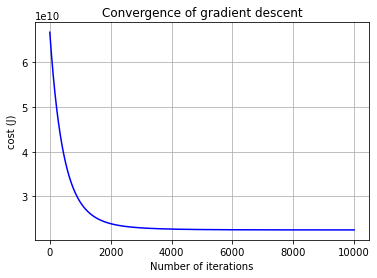

Total no of test examples (m) = 1681 

[228553.60900847 117025.76409526  64776.79953388 ... 104553.17174424
 262261.74173743  61491.82552502]
[220000.  36000.  96200. ... 117000. 300000.  56000.]
PartOfTheCity   -0.135725
ObjectType      -0.048548
SquareFootage    0.640440
TotalRooms       0.393188
Price            1.000000
Name: Price, dtype: float64
Total no of training examples (m) = 8403 



In [4]:
from tkinter import *
class MyWindow:
    def __init__(self, win):
        self.linearRegression = LinearRegressionApp()
        self.linearRegression.mainProg()
        self.kNearestNeighbors = KNearestNeighbors()
        self.kNearestNeighbors.dataFrame = self.linearRegression.dataFrame
        self.kNearestNeighbors.kNearestNeighborsFunc()
        self.lbl1=Label(win, text='Opstina: ')
        self.lbl2=Label(win, text='Tip gradnje: ')
        self.lbl3=Label(win, text='Kvadratura: ')
        self.lbl4=Label(win, text='Broj soba: ')
        self.lbl5=Label(win, text='Parametar k: ')
        self.lbl6=Label(win, text='Procenjena cena: ')
        self.t1=Entry(bd=3)
        self.t2=Entry()
        self.t3=Entry()
        self.t4=Entry()
        self.t5=Entry()
        self.t6=Entry()
        self.v0=IntVar()
        self.v0.set(1)
        self.r1=Radiobutton(window, text="Euklidska distanca", variable=self.v0,value=1)
        self.r2=Radiobutton(window, text="Cebiseva distanca", variable=self.v0,value=2)
    
        self.lbl1.place(x=100, y=50)
        self.t1.place(x=200, y=50)
        self.lbl2.place(x=100, y=100)
        self.t2.place(x=200, y=100)
        self.lbl3.place(x=100, y=150)
        self.t3.place(x=200, y=150)
        self.lbl4.place(x=100, y=200)
        self.t4.place(x=200, y=200)
        self.lbl5.place(x=100, y=250)
        self.t5.place(x=200, y=250)
        self.r1.place(x=100,y=300)
        self.r2.place(x=250, y=300)
        self.b1=Button(win, text='Linearna regresija', command=self.evaluateLinearRegression)
        self.b2=Button(win, text='K-najblizih suseda', command=self.evaluateKNearestNeighbors)
        self.b1.place(x=100, y=350)
        self.b2.place(x=250, y=350)
        self.lbl6.place(x=100, y=400)
        self.t6.place(x=200, y=400)
    def evaluateLinearRegression(self):
        self.t6.delete(0, 'end')
        partOfTheCity = self.t1.get()
        objectType = self.t2.get()
        squareFootage = self.t3.get()
        totalRooms = self.t4.get()
        dataFrame = self.linearRegression.createDataFrame([(partOfTheCity, objectType, squareFootage, totalRooms, 1)])
        dataFrame=self.linearRegression.initDataFrame(dataFrame)
        result = self.linearRegression.applyLinearRegressionToTestData(dataFrame)
        self.t6.insert(END, str(result))
    def evaluateKNearestNeighbors(self):
        self.t6.delete(0, 'end')
        partOfTheCity = self.t1.get()
        objectType = self.t2.get()
        squareFootage = self.t3.get()
        totalRooms = self.t4.get()
        k=5
        try:
            print(self.t5.get())
            k = int(self.t5.get())
        except ValueError:
            k = 5
        dataFrame = self.linearRegression.createDataFrame([(partOfTheCity, objectType, squareFootage, totalRooms, 1)])
        dataFrame=self.linearRegression.initDataFrame(dataFrame)
        newRealEstate = dataFrame.values[:, 0:4]
        result = self.kNearestNeighbors.classifyRealEstate(newRealEstate, k, self.v0.get())
        self.t6.insert(END, str(result))

window=Tk()
mywin=MyWindow(window)
window.title('Hello Python')
window.geometry("700x600+10+10")
window.mainloop()